# Modelling and Evaluating Notebook

### Objectives
* Answer second business requirement:
  The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

### Inputs
* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* inputs/cherry_leaves_dataset/cherry-leaves/test
* image shape embeddings

### Outputs
* Images distribution plot in train, validation and test set
* Image augmentation
* Class indices to change prediction inference in labels
* ML model creation and training
* Saving model
* Ploting learning curve for model performance
* Model evaluation on pickle file
* Prediction on the randome image file

### Additional Comments
* No additional comments

---

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/milestone-project-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/milestone-project-mildew-detection-in-cherry-leaves'

## Set Input Directories

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set Output Directories

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label Names

In [7]:
labels = os.listdir(train_path)
print('Labels for the images are', labels)

Labels for the images are ['powdery_mildew', 'healthy']


## Set Image Shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, validation and test set

Image distribution: Loop through data (sets), determine image frequency and plot results on bar graph

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images


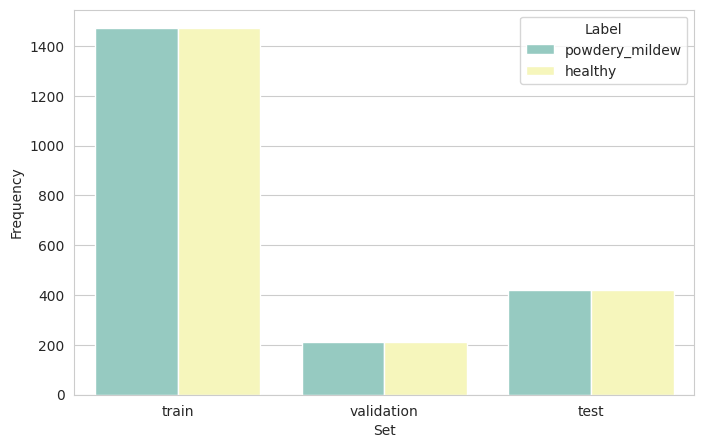

In [14]:
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])


folders = ['train', 'validation', 'test']

# Iterate through folders and labels to count images
for folder in folders:
    for label in labels:
        folder_path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(folder_path))
        df_freq = df_freq.append({'Set': folder, 'Label': label, 'Frequency': num_images}, ignore_index=True)
        print(f"* {folder} - {label}: {num_images} images")

# Plot the distribution of labels
sns.set_style("whitegrid")
sns.set_palette("Set3")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

# Image Data Augmentation

By looking at the plot graf above we can notice that the number of images in train set is not sufficient for deep neural network learning model. To solve this problem we will increase the number of images by generating modified versions of the existing images. Process is called Image Augmentation. That will also help models generalize more effectively and improve their ability to recognize and interpret new images.

---

### ImageDataGenerator

### Import and Initialize ImageDataGenerator

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training image dataset

In [17]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [18]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [19]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented images

* Augmented training image

(20, 256, 256, 3)


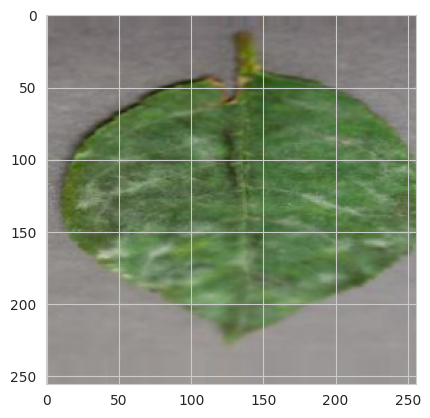

(20, 256, 256, 3)


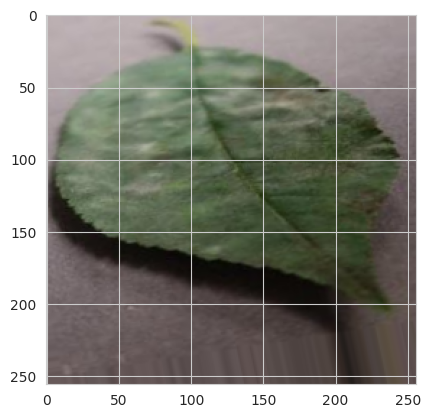

(20, 256, 256, 3)


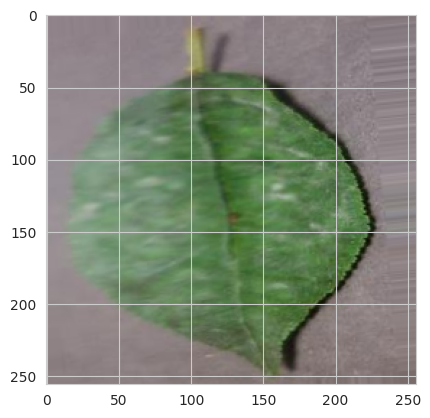

In [19]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

* Augmented validation image

(20, 256, 256, 3)


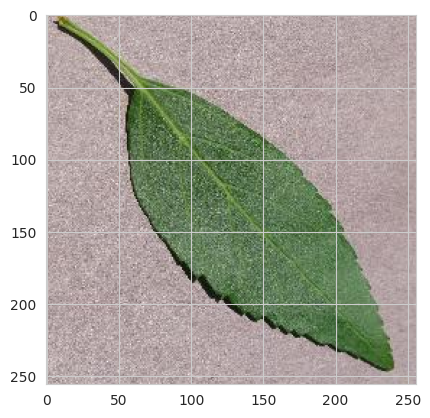

(20, 256, 256, 3)


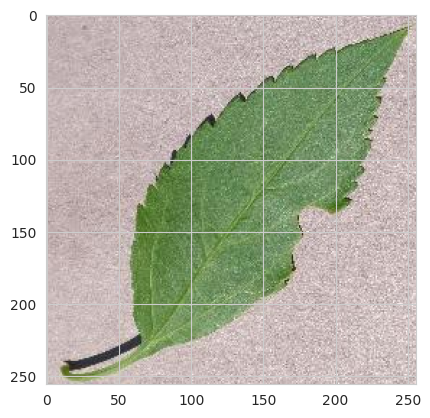

(20, 256, 256, 3)


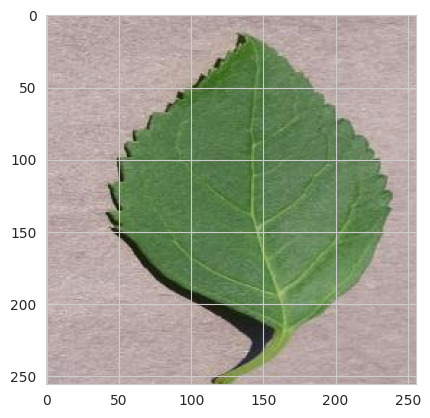

In [20]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

* Augmented test image

(20, 256, 256, 3)


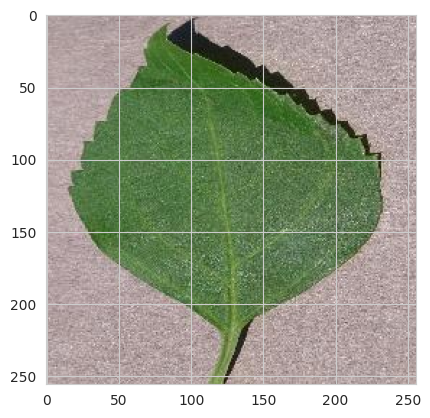

(20, 256, 256, 3)


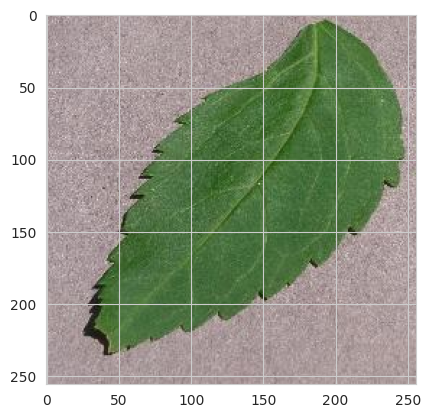

(20, 256, 256, 3)


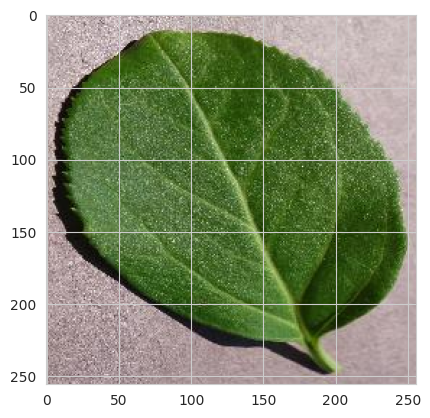

In [27]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[1])
    plt.show(1)

In [20]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

MODEL CREATION

ML Model

import model packages

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

tf model

In [10]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model summary

In [11]:
create_tf_model().summary()

2023-11-16 16:14:28.487891: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0

early stopping

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

fit model for model training

In [21]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2023-11-16 16:24:30.013570: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 217s 1s/step - loss: 0.3468 - accuracy: 0.8372 - val_loss: 0.0438 - val_accuracy: 0.9857
Epoch 2/25
147/147 [==============================] - 165s 1s/step - loss: 0.0441 - accuracy: 0.9887 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 3/25
147/147 [==============================] - 168s 1s/step - loss: 0.0441 - accuracy: 0.9856 - val_loss: 0.0444 - val_accuracy: 0.9857
Epoch 4/25
147/147 [==============================] - 167s 1s/step - loss: 0.0294 - accuracy: 0.9908 - val_loss: 1.5083e-04 - val_accuracy: 1.0000
Epoch 5/25
147/147 [==============================] - 169s 1s/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.0164 - val_accuracy: 0.9976
Epoch 6/25
147/147 [==============================] - 170s 1s/step - loss: 0.0301 - accuracy: 0.9904 - val_loss: 0.0066 - val_accuracy: 0.9976
Epoch 7/25
147/147 [==============================] - 165s 1s/step - loss: 0.0434 - accuracy: 0.9846 - val_loss: 0.0034 - val_accuracy: 0.

save model

In [22]:
model.save('outputs/v1/mildew_detection_tf_model.h5')

MODEL PERFORMANCE

model learning curve

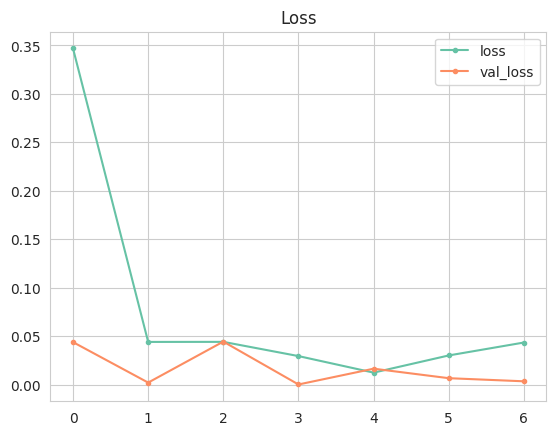

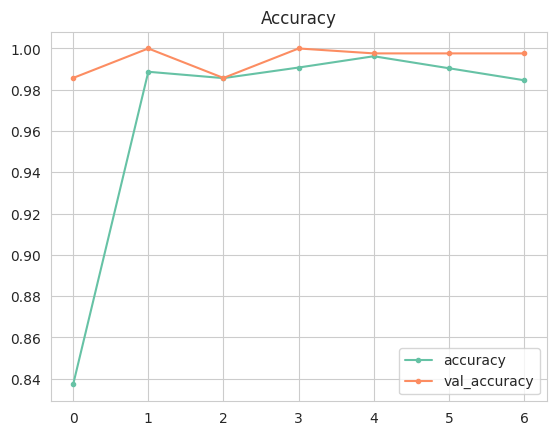

In [23]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
sns.set_palette("Set2")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

MODEL EVALUATION

load saved model

In [25]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detection_tf_model.h5')

Evaluate model on test set

In [26]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 12s 274ms/step - loss: 0.0268 - accuracy: 0.9941


Save evaluation pickle file

In [28]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

PREDICT NEW DATA

load random image 

Image shape: (256, 256), Image mode: RGB


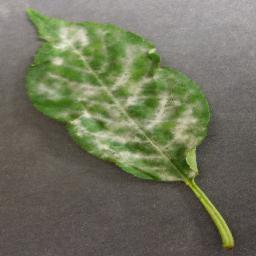

In [30]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select healthy or mildew

leaf_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {leaf_image.size}, Image mode: {leaf_image.mode}')
leaf_image

In [31]:
my_image = image.img_to_array(leaf_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


In [34]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(f'Prediction probability: {pred_proba}')
print(f'Predicted class: {pred_class}')

Prediction probability: 1.0
Predicted class: powdery_mildew
